# GCN Experiments

# SROIE 2019 Dataset Exploration

In [1]:
import torch
torch.cuda.is_available()

True

# Information Extraction with GCN
* * *
The goal of this notebook is to show how to use a gcn classifier to tag text items that OCR has identified in a structured document like a receipt.

We use the SROIE 2019 dataset, which is a dataset of scanned images of receipts, with two levels of anotations:
1. OCR output: for each image, a list of text items and their bounding boxes
* Information Extraction output: for each image, a jason file with 4 properties: 
    - company
    * date
    * address
    * total

We train a GCN to classify text items in (1) into one of the following 5 classes:
- company
* date
* address
* total
* IGNORE

## Configuration

In [116]:
# information extraction
items_to_extract = ["company", "date", "address", "total", "IGNORE"]

# dataset
dataset_str = "0325updated.task1train(626p)"
task1train_dir = "/home/adrian/as/blogs/nanonets/datasets/SROIE2019-20191212T043930Z-001/SROIE2019/{}/".format(dataset_str)


## Reading the image and anotations

In [45]:
import os

def get_file_paths(dataset_dir):
    images, labels = [], []
    for r, d, f in os.walk(dataset_dir):
        for file in f:
            filename = file.split('/')[-1]
            if '(' in filename:
                continue
            if filename.endswith(".jpg"):
                images.append(filename)
            elif filename.endswith(".txt"):
                labels.append(filename)
    return list(zip(sorted(images), sorted(labels)))

### Parsing the labels

In [92]:
def get_text_items(annotation_file):
    items = []
    with open(annotation_file, 'r') as f:
        for line in f:
            row = line.strip().split(',')
            x0, y0, x1, y1, x2, y2, x3, y3 = row[:8]
            x0, y0, x2, y2 = int(x0), int(y0), int(x2), int(y2)
            text = ','.join(row[8:])
            item = (x0, y0, x2, y2, text)
            items.append(item)
    return items

## Plotting the labels on the images

In [107]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

def plot_image(image_file, annotation_file, item_indices=[0]):
    # load color (BGR) image
    # BGR is the same as RGB (just inverse byte order), OpenCV adopted it for historical reasons.
    img = cv2.imread(image_file)

    # get text items in image
    text_items = get_text_items(annotation_file)

    # get bounding box for each detected text item
    for i in item_indices:
        top_left_x, top_left_y, bottom_right_x, bottom_right_y, text = text_items[i]

        # add bounding box to color image
        cv2.rectangle(img,(top_left_x, top_left_y), (bottom_right_x, bottom_right_y),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.figure(figsize = (10,20))
    plt.imshow(cv_rgb)
    plt.show()

626


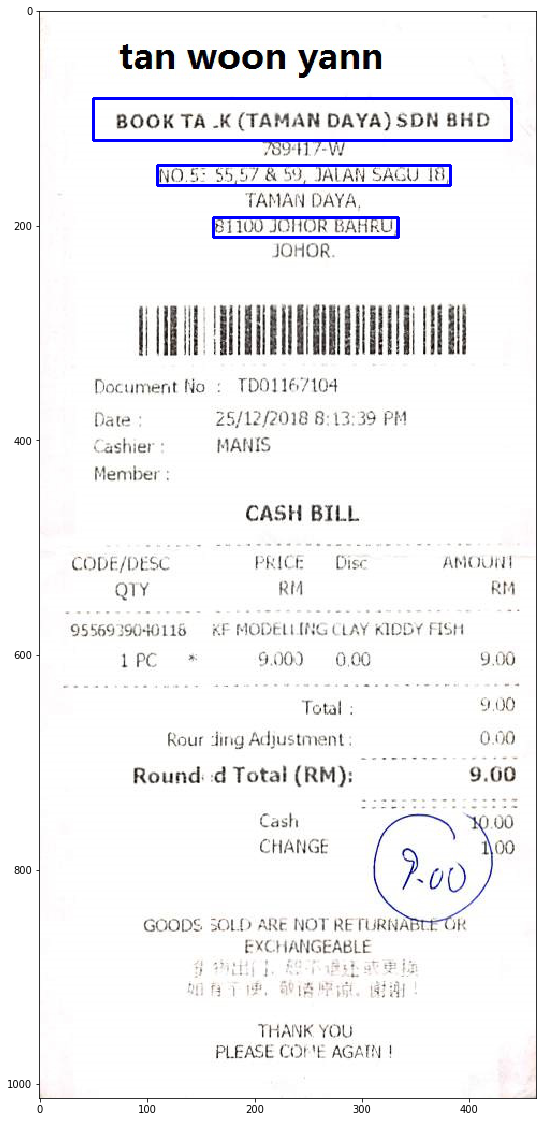

In [113]:
# find files
task1train_files = get_file_paths(task1train_dir)
print(len(task1train_files))

# select a file to display
(img, ann) = task1train_files[0]
image_file = os.path.join(task1train_dir, img)
annotation_file = os.path.join(task1train_dir, ann)

# Select a few items to highlight
item_indices = [1, 3, 5]

# read and show annotated file
plot_image(image_file, annotation_file, item_indices)

# Data Normalization

## Reformating SROIE labels files as GCN input files
* * *
as scipy.sparse.csr.csr_matrix:
- ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
* ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
* ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances;

as numpy.ndarray:
- ind.dataset_str.y => the one-hot labels of the labeled training instances;
* ind.dataset_str.ty => the one-hot labels of the test instances;
* ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx;


as collections.defaultdict:
- ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]};


as list:
- ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting.


All objects above must be saved using python pickle module.

#### Definitions:
- param dataset_str: Dataset name
* training instance:
* feature vector:
* labels:

## Reading CSR file and plotting the labels over the images 


# Modeling

## Training the GCN with the Task1 labels as input to predict task 2 as output

### Show Extracted information (task 2 output) from task 1 labels